In [1]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 20.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 2.8 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape

# import sounddevice as sd
import os
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm

2023-05-18 17:58:09.181590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo 

!cat /proc/meminfo  | grep "Mem" #especificações de RAM

TPU not found
Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1']



2023-05-18 17:58:23.857178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-18 17:58:24.111386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-18 17:58:24.111945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 0
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 1
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 2
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 3
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 4
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 5
cpu cores	: 6

MemTotal:       16334184 kB
MemFree:         6725308 kB
MemAvailable:   13324320 kB


In [4]:
def load_wav(filename):
    # Load the WAV file
    sample_rate, data = wavfile.read(filename)

    # Convert the data to float32 values between -1 and 1
    data = np.float32(data / 32767.0)
    return data

In [5]:
pesq_dataset_path = './BasePESQ'

In [6]:
# Listar pastas dos sons gerados
folders = os.listdir(pesq_dataset_path)

In [7]:
# Lista para armazenar os dados de treinamento
train_data = []
train_labels = []

# Loop pelas pastas dos sons gerados
for person_folder in tqdm(folders[:20]):
    people_folders = os.path.join(pesq_dataset_path, person_folder)
    # Lista de todos as pastas de som na pasta atual
    person_audios_folders = os.listdir(people_folders)
    
    for sample_folder in person_audios_folders:
        sound_files_folder = os.path.join(people_folders, sample_folder)
        sound_files = os.listdir(sound_files_folder)
        # Loop pelos arquivos
        for file in sound_files: #nível de amostra
            sff = os.path.join(sound_files_folder, file)
            
            original_sound = load_wav(os.path.join(sff, 'original.wav'))
            
            degraded_sounds = glob(os.path.join(sff, 'PESQ*.wav'))
            
            for d_sound_path in degraded_sounds:
#                 file_path = os.path.join(sff, d_sound)

                # Carregar o som
                d_sound = load_wav(d_sound_path)
                
                # Obter o resultado da PESQ a partir do nome do arquivo
                pesq_result = float(os.path.basename(d_sound_path).split('_')[1])
                
                original_sound = original_sound.reshape((6400, 1))
                d_sound = d_sound.reshape((6400, 1))
                
                merged_array = np.concatenate((original_sound, d_sound), axis=1)
                # Adicionar os dados de treinamento
                train_data.append(merged_array)
                train_labels.append(pesq_result)
                
train_data = np.array(train_data)
train_labels = np.array(train_labels).reshape(-1, 1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it]


In [8]:
min_val = np.min(train_labels)
max_val = np.max(train_labels)

normalized_labels = (train_labels - min_val) / (max_val - min_val)

In [9]:
# Define the proportion of data to use for training, validation, and test
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

In [10]:
# Split the data and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data, normalized_labels, test_size=test_prop)

# Split the training data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_prop/train_prop)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(31825, 6400, 2)
(31825, 1)
(15914, 6400, 2)
(15914, 1)


In [12]:
print(np.max(X_train))
print(np.max(y_train))
print(np.max(X_val))
print(np.max(y_val))

1.0
1.0
1.0
1.0


In [13]:
print(np.min(X_train))
print(np.min(y_train))
print(np.min(X_val))
print(np.min(y_val))

-1.0000305
0.0
-1.0000305
0.0


In [14]:
def cnn():
    # Define the input shape
    input_shape = (6400, 2)

    # Define the model architecture
    input_layer = Input(shape=input_shape)

    conv1 = Conv1D(16, 3, activation='relu')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(32, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    flatten = Flatten()(pool2)
    dense1 = Dense(64, activation='relu')(flatten)
    output_layer = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [15]:
model = cnn()

2023-05-18 18:01:48.657357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-18 18:01:48.735141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-18 18:01:48.735642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6400, 2)]         0         
                                                                 
 conv1d (Conv1D)             (None, 6398, 16)          112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3199, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 3197, 32)          1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1598, 32)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 51136)             0     

In [17]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

2023-05-18 18:02:02.911028: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1629440000 exceeds 10% of free system memory.
2023-05-18 18:02:04.064843: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1629440000 exceeds 10% of free system memory.


Epoch 1/10


2023-05-18 18:02:14.395279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-18 18:02:26.262533: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1504004200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-18 18:02:26.262633: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2023-05-18 18:02:27.123623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-18 18:02:30.130745: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


498/498 [==============================] - ETA: 0s - loss: 0.0209

2023-05-18 18:02:41.690731: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 814796800 exceeds 10% of free system memory.
2023-05-18 18:02:48.132742: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 814796800 exceeds 10% of free system memory.


498/498 [==============================] - 53s 50ms/step - loss: 0.0209 - val_loss: 0.0095
Epoch 2/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 3/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 4/10
498/498 [==============================] - 10s 20ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/10
498/498 [==============================] - 9s 19ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/10
498/498 [==============================] - 9s 18ms/step - loss: 0.0015 - val_loss: 0.001

2023-05-18 18:04:20.930193: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 611072000 exceeds 10% of free system memory.


0.0009738794178701937


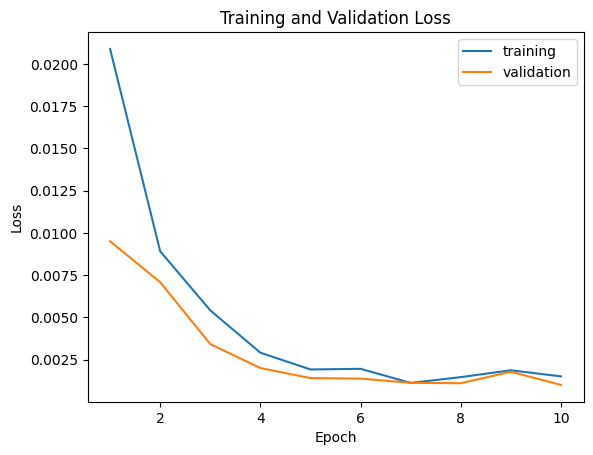

In [18]:
model.compile(optimizer='adam', loss='mse',)
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[PlotLossesCallback()])

score = model.evaluate(X_test, y_test, verbose=0)
print(score)
model.save('pesq.h5')